# Exploratory Data Analysing Using Youtube Video Data from Most Popular Data Science Channels

## I. Mục tiêu và mục đích

Trong dự án này, mình muốn tìm câu trả lời những ý sau:

- Tìm hiểu về API Youtube và cách lấy dữ liệu video.
- Phân tích dữ liệu video của các kênh youtube phổ biến khác nhau về những gì làm cho một video hoạt động tốt trên Youtube, ví dụ:
- Số lượt thích và bình luận có quan trọng để video có nhiều lượt xem hơn không?
- Thời lượng video có quan trọng đối với lượt xem và tương tác (lượt thích/bình luận) không?
- Độ dài tiêu đề có quan trọng đối với lượt xem không?
- Video có nhiều lượt xem có bao nhiêu tag? Các tag phổ biến trong số các video này là gì?
- Trong số tất cả những creator mà mình cân nhắc, họ tải video mới lên thường xuyên như thế nào? Vào những ngày nào trong tuần?
- Khám phá các chủ đề thịnh hành bằng các kỹ thuật NLP
- Những chủ đề phổ biến nào đang được đề cập trong các video (ví dụ: sử dụng wordcloud cho tiêu đề video)?
- Những câu hỏi nào đang được đặt ra trong phần bình luận trong video

## I. Các bước của dự án
1. Thu thập siêu dữ liệu video thông qua Youtube API cho 5 kênh hàng đầu trong lĩnh vực khoa học dữ liệu (bao gồm một số bước nhỏ: tạo khóa nhà phát triển, yêu cầu dữ liệu và chuyển đổi phản hồi thành định dạng dữ liệu có thể sử dụng)
2. Tiền xử lý dữ liệu và thiết kế các tính năng bổ sung để phân tích
3. Phân tích dữ liệu thăm dò
4. Kết luận

In [1]:
import pandas as pd
import numpy as np
from dateutil import parser
!pip install isodate
import isodate

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# Google API
!pip install google-api-python-client
from googleapiclient.discovery import build

In [2]:
# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
!pip install wordcloud
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 1.  Sử dụng Youtube API để tạo bản dữ liệu

Các bược thực hiện:
- B1: Mình sẽ tạo một project trên Google Developers Console -> requested an authorization credential (API key)
- B2: Mình bật Youtube API để có thể gửi yêu cầu API đến các dịch vụ Youtube API
- B3: Mình sẽ vào các kênh Youtube mà mình muốn phân tích để lấy địa chỉ ID
- B4: Mình sẽ tạo các functions để lấy số liệu thống kê những kênh này thông qua API
(Let's get started ^-^)

In [40]:
api_key = '...' # "Create your own API and put it at the '...' mark."

channel_ids = ['UCdngmbVKX1Tgre699-XLlUA', # TechWorld with Nana
               'UCJQJAI7IjbLcpsjWdSzYz0Q', # Thu Vu khoa học số liệu
               'UCSQvwTdavISOusGhJW6H0Vg', # Absent Data
               'UC7cs8q-gJRlGwj4A8OmCmXg', # Alex the analyst
               'UCh9nVJoWXmFb7sLApWGcLPQ', # codebasics
              ]

youtube = build('youtube', 'v3', developerKey=api_key)

In [4]:
def get_channel_stats(youtube, channel_ids):
 # Tạo một hàm để lấy dữ liệu thống kê channel gồm : tiêu đề, số lượng người đăng ký, số lượng view, số lượng video và playlist Id của kênh
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute()

    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)

    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    # Hàm dùng để lấy các thông tin video Id của tất cả các video trong playlist

    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()

    video_ids = []

    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    more_pages = True

    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()

            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])

            next_page_token = response.get('nextPageToken')

    return video_ids

def get_video_details(youtube, video_ids):
    # Tạo hàm lấy dữ liệu video của tất cả các video id đã lấy ở hàm phía trên

    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

def get_comments_in_videos(youtube, video_ids):
   # Tạo hàm lấy thông tin top 10 các comment
    all_comments = []

    for video_id in video_ids:
        try:
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()

            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)

        except:
            # Nếu xãy ra lỗi rất có thể tính năng bình luận đã bị tắt
            print('Could not get comments for video ' + video_id)

    return pd.DataFrame(all_comments)

#### 1.1 Lấy dữ liệu thống kê kênh

Sử dụng hàm get_channel_stats đã được định nghĩa ở trên để lấy các thông tin sau của 5 channel trong phạm vi nghiên cứu:
- Tên channel
- Số lượng subscribers
- Số lượt view
- Tổng số lượng video trên từng channel
- Playlist ID


In [5]:
channel_data = get_channel_stats(youtube, channel_ids)
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,TechWorld with Nana,1180000,62774780,125,UUdngmbVKX1Tgre699-XLlUA
1,Thu Vu data analytics,279000,9666912,90,UUJQJAI7IjbLcpsjWdSzYz0Q
2,codebasics,1170000,108794824,998,UUh9nVJoWXmFb7sLApWGcLPQ
3,Alex The Analyst,933000,43311713,338,UU7cs8q-gJRlGwj4A8OmCmXg
4,Absent Data,51000,3903311,221,UUSQvwTdavISOusGhJW6H0Vg


In [6]:
channel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   channelName  5 non-null      object
 1   subscribers  5 non-null      object
 2   views        5 non-null      object
 3   totalVideos  5 non-null      object
 4   playlistId   5 non-null      object
dtypes: object(5)
memory usage: 328.0+ bytes


Note: Sau khi kiểm tra kiểu dữ liệu của các cột trong bảng channel_data, hiện tại có cột subscribers, views,totalVideos đáng có kiểu dữ liệu string -> Mình sẽn convert chúng sang numberic để có thể visualize


In [7]:
numeric_cols = ['subscribers','views','totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors = 'coerce' )

In [8]:
channel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   channelName  5 non-null      object
 1   subscribers  5 non-null      int64 
 2   views        5 non-null      int64 
 3   totalVideos  5 non-null      int64 
 4   playlistId   5 non-null      object
dtypes: int64(3), object(2)
memory usage: 328.0+ bytes


=> Các cộtsubscribers, views,totalVideos đã chuyển sang dạng số

<ipython-input-9-9397156a24a2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='subscribers', y='channelName', data=channel_data.sort_values('subscribers', ascending=False),palette='viridis')
<ipython-input-9-9397156a24a2>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels())


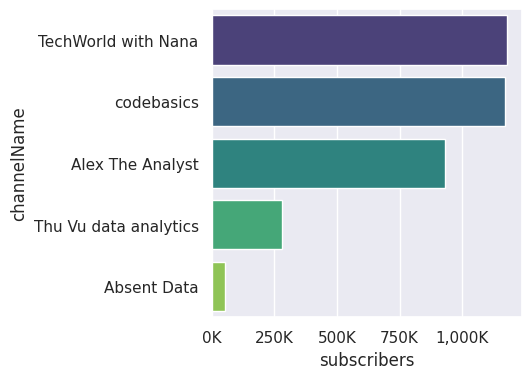

In [9]:
# Sử dụng barchart xem xét số lượng người đăng ký trên mỗi kênh
# -> để biết mức độ phổ biến của các kênh khi so sánh với nhau.
sns.set(rc={'figure.figsize':(4,4)})
ax = sns.barplot(x='subscribers', y='channelName', data=channel_data.sort_values('subscribers', ascending=False),palette='viridis')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels())

<ipython-input-10-66e8e7eefb01>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='views', y='channelName', data=channel_data.sort_values('views', ascending=False),palette='viridis')
<ipython-input-10-66e8e7eefb01>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels())


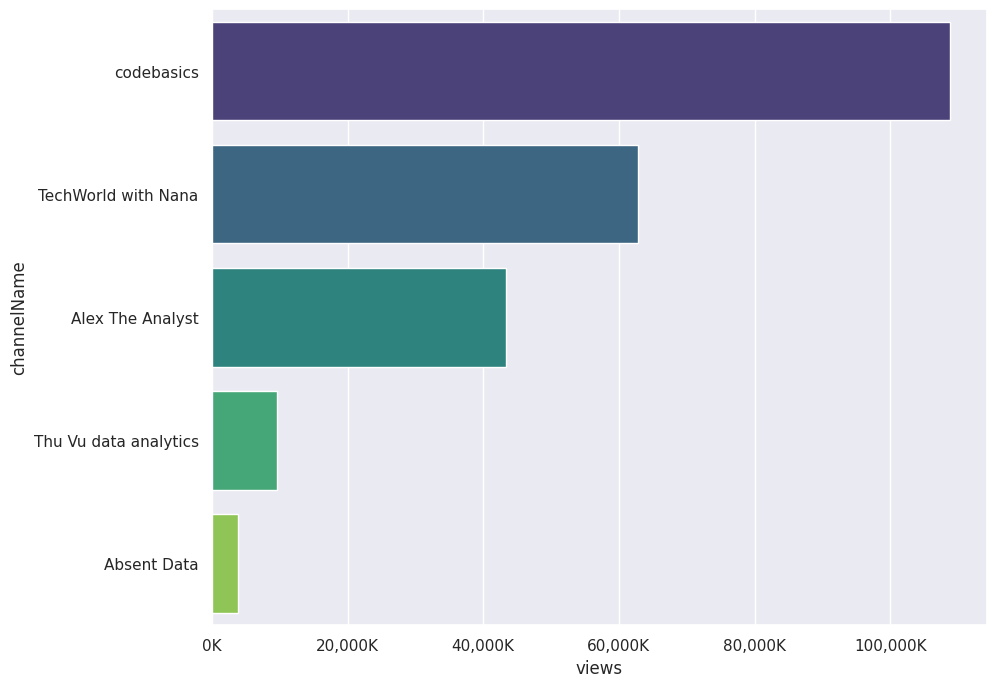

In [10]:
# Sử dụng barchart để xem xét số lượt view trên mỗi kênh
# -> để biết mức độ phổ biến của các kênh khi so sánh với nhau.
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='views', y='channelName', data=channel_data.sort_values('views', ascending=False),palette='viridis')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels())

- Ta có thể dễ dàng nhận thấy rằng 3 kênh 'Thu vu data analytics', 'Alex The Analyst', 'Absent' có thứ hạng xét theo tổng số lượt xem của các kênh khá giống với thứ hạng số lượng người đăng ký.
- 'Codebasic' và 'TechWork' with Nana vẫn là hai kênh phổ biến nhất xét theo cả số người đăng ký và lượt xem. Điều thú vị là 2 kênh này có số người đăng ký chênh lệch không nhiều, nhưng kênh 'Codebasic' có lượt đăng ký ít hơn lại có số lượt view gần gắp đôi kênh 'TechWork'.

### 1.2 Get dữ liệu thống kê của tất cả các video

Trong bước tiếp theo, mình sẽ lấy số liệu thống kê video cho tất cả các kênh. Tổng cộng, số dòng lấy được là 1649 video như được hiển thị bên dưới.

In [11]:
# Create a dataframe with video statistics and comments from all channels

video_df = pd.DataFrame()
comments_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)

    # get video data
    video_data = get_video_details(youtube, video_ids)

    # get comment data
    comments_data = get_comments_in_videos(youtube, video_ids)

    # # Append video data together and comment data together using pd.concat
    video_df = pd.concat([video_df, video_data], ignore_index=True)
    comments_df = pd.concat([comments_df, comments_data], ignore_index=True)

Getting video information from channel: TechWorld with Nana
Getting video information from channel: Thu Vu data analytics
Getting video information from channel: codebasics
Getting video information from channel: Alex The Analyst
Getting video information from channel: Absent Data


In [12]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,1J2YOV6LcwY,TechWorld with Nana,Complete DevOps Roadmap 2025 - Master these 4 ...,Master the 4 Stages of Learning DevOps to beco...,"[devops roadmap, how to become a devops engine...",2024-12-17T15:04:18Z,29990,1337,None,75,PT37M53S,hd,false
1,q8OleYuqntY,TechWorld with Nana,Full NGINX Tutorial - Demo Project with Node.j...,Full NGINX Tutorial for Beginners - Even if yo...,"[nginx tutorial, what is nginx, nginx reverse ...",2024-11-14T15:15:17Z,79716,3613,None,163,PT1H11M40S,hd,false
2,XCZWyN9ZbEQ,TechWorld with Nana,Full Golang Tutorial - Learn Go by Building a ...,A Complete Go Crash Course for Beginners to le...,"[golang, programming, go tutorial, golang tuto...",2024-10-14T13:22:24Z,69288,2295,None,91,PT1H34M56S,hd,false
3,xo5V9g9joFs,TechWorld with Nana,Proxy vs Reverse Proxy vs Load Balancer | Simp...,Understand the difference of Forward Proxy vs ...,"[proxy vs reverse proxy, reverse proxy explain...",2024-09-10T14:06:02Z,232075,8868,None,177,PT13M19S,hd,false
4,iInUBOVeBCc,TechWorld with Nana,NGINX Explained - What is Nginx,"Learn what is Nginx, why do we need it, Nginx ...","[nginx tutorial, what is nginx, nginx reverse ...",2024-08-06T14:09:50Z,281816,10793,None,298,PT14M32S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1767,qummiNwSsqA,Absent Data,Track Outbound Links with Google Tag Manager,Track your external website links with the hel...,[Google Tag Manager],2016-08-21T11:49:59Z,13373,42,None,13,PT5M24S,hd,false
1768,ykI1yk0FzfY,Absent Data,Adjusted Bounce Rate with Google Tag Manager,Learn how to adjust your bounce rate to reflec...,"[Google Tag Manager, Bounce Rate.]",2016-07-16T08:04:50Z,1818,4,None,0,PT5M28S,hd,false
1769,f4PzewUT8Dw,Absent Data,The Best Time of Day to Publish a Blog Post,Use your website's analytics to know identify ...,"[blogging, analytics]",2016-04-24T14:42:10Z,265,4,None,0,PT3M59S,sd,false
1770,Em0wU0Ac3f0,Absent Data,Track Button Clicks in Google Tag Manager,Track Button Clicks with these easy step by st...,"[analytics, google tag manager, tracking]",2016-04-14T15:32:57Z,9891,73,None,30,PT8M45S,sd,false


Chỉ có tổng cộng 1773 bình luận vì mình giới hạn 10 bình luận đầu tiên trên video để tránh vượt quá giới hạn hạn ngạch của Youtube API.

In [13]:
comments_df

,video_id,comments
0,1J2YOV6LcwY,[I hope this is useful for you guys to start y...
1,q8OleYuqntY,"[Many of you have requested a demo with NGINX,..."
2,XCZWyN9ZbEQ,[▬▬▬▬▬▬ R E S O U R C E S 🔗 ▬▬▬▬▬▬ \n► Gi...
3,xo5V9g9joFs,[👉 Continue with the Nginx Crash Course you we...
4,iInUBOVeBCc,[👉 Here the follow up video to clarify the dif...
...,...,...
1767,qummiNwSsqA,"[Okay, I did all of this. I saw the link worki..."
1768,ykI1yk0FzfY,[]
1769,f4PzewUT8Dw,[]
1770,Em0wU0Ac3f0,"[Hi, How do we track multiple download at same..."


In [14]:
# Lưu lại file CSV dữ liệu video và dữ liệu comments
video_df.to_csv('video_data_top10_channels.csv')
comments_df.to_csv('comments_data_top10_channels.csv')

## 2. Preprocessing & Feature engineering
Để có thể sử dụng dữ liệu và phân tích, mình sẽ thực hiện một số bước pre-processing.
- B1: định dạng lại một số cột, đặc biệt là các cột ngày và giờ như "pushlishedAt" và "duration".
- B2: làm giàu dữ liệu bằng một số tính năng mới có thể hữu ích để hiểu các đặc điểm của video.

In [15]:
#Kiểm tra các giá trị empty
video_df.isnull().sum()

,0
video_id,0
channelTitle,0
title,0
description,0
tags,338
publishedAt,0
viewCount,0
likeCount,0
favouriteCount,1772
commentCount,0


In [16]:
video_df.publishedAt.sort_values().value_counts()

,count
publishedAt,
2019-05-08T04:51:05Z,17
2019-05-08T04:51:06Z,9
2015-12-20T01:21:07Z,1
2023-08-18T15:30:01Z,1
2023-08-17T14:31:36Z,1
...,...
2021-03-21T16:15:06Z,1
2021-03-20T14:30:11Z,1
2021-03-19T14:30:13Z,1


Tiếp theo, chúng ta cần kiểm tra xem kiểu dữ liệu của các cột có đúng không. Tôi đã kiểm tra các kiểu dữ liệu và thực tế một số cột đếm như số lượt xem và số bình luận hiện không có kiểu dữ liệu đúng. Trong bước này, chúng ta chuyển đổi các cột đếm này thành số nguyên.

In [17]:
# Kiểm tra những cột có sẵn trong video_df
available_cols = video_df.columns
print("Available columns:", available_cols)

# Filter only the columns that exist in the DataFrame
cols = [col for col in ['viewCount', 'likeCount', 'favoriteCount', 'commentCount'] if col in available_cols]

# Apply the conversion to numeric, only on the available columns
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

Available columns: Index(['video_id', 'channelTitle', 'title', 'description', 'tags',
       'publishedAt', 'viewCount', 'likeCount', 'favouriteCount',
       'commentCount', 'duration', 'definition', 'caption'],
      dtype='object')


## 2.1  Enriching data

Tôi muốn làm giàu dữ liệu để phân tích sâu hơn, ví dụ:

- tạo cột ngày xuất bản với một cột khác hiển thị ngày trong tuần video được xuất bản, điều này sẽ hữu ích cho việc phân tích sau này.

- chuyển đổi thời lượng video thành giây thay vì định dạng chuỗi mặc định hiện tại

- tính toán số lượng thẻ cho mỗi video

- tính toán bình luận và lượt thích trên tỷ lệ 1000 lượt xem

- tính toán độ dài ký tự tiêu đề

In [18]:
# Create publish day (in the week) column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['published_day_name'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [19]:
# convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [20]:
# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [21]:
# Comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [22]:
# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

In [23]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,published_day_name,durationSecs,tagsCount,likeRatio,commentRatio,titleLength
0,1J2YOV6LcwY,TechWorld with Nana,Complete DevOps Roadmap 2025 - Master these 4 ...,Master the 4 Stages of Learning DevOps to beco...,"[devops roadmap, how to become a devops engine...",2024-12-17 15:04:18+00:00,29990,1337,None,75,PT37M53S,hd,false,Tuesday,0 days 00:37:53,9,44.581527,2.500834,53
1,q8OleYuqntY,TechWorld with Nana,Full NGINX Tutorial - Demo Project with Node.j...,Full NGINX Tutorial for Beginners - Even if yo...,"[nginx tutorial, what is nginx, nginx reverse ...",2024-11-14 15:15:17+00:00,79716,3613,None,163,PT1H11M40S,hd,false,Thursday,0 days 01:11:40,25,45.323398,2.044759,55
2,XCZWyN9ZbEQ,TechWorld with Nana,Full Golang Tutorial - Learn Go by Building a ...,A Complete Go Crash Course for Beginners to le...,"[golang, programming, go tutorial, golang tuto...",2024-10-14 13:22:24+00:00,69288,2295,None,91,PT1H34M56S,hd,false,Monday,0 days 01:34:56,27,33.122619,1.313359,58
3,xo5V9g9joFs,TechWorld with Nana,Proxy vs Reverse Proxy vs Load Balancer | Simp...,Understand the difference of Forward Proxy vs ...,"[proxy vs reverse proxy, reverse proxy explain...",2024-09-10 14:06:02+00:00,232075,8868,None,177,PT13M19S,hd,false,Tuesday,0 days 00:13:19,18,38.211785,0.762684,58
4,iInUBOVeBCc,TechWorld with Nana,NGINX Explained - What is Nginx,"Learn what is Nginx, why do we need it, Nginx ...","[nginx tutorial, what is nginx, nginx reverse ...",2024-08-06 14:09:50+00:00,281816,10793,None,298,PT14M32S,hd,false,Tuesday,0 days 00:14:32,21,38.298038,1.057428,31


In [24]:
video_df.to_csv('video_data_top10_channels_Enriching data.csv')

## 3. Exploratory data analysis

<ipython-input-25-6d3e88b1b540>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='channelTitle', y='viewCount', data=video_df, palette='pastel')


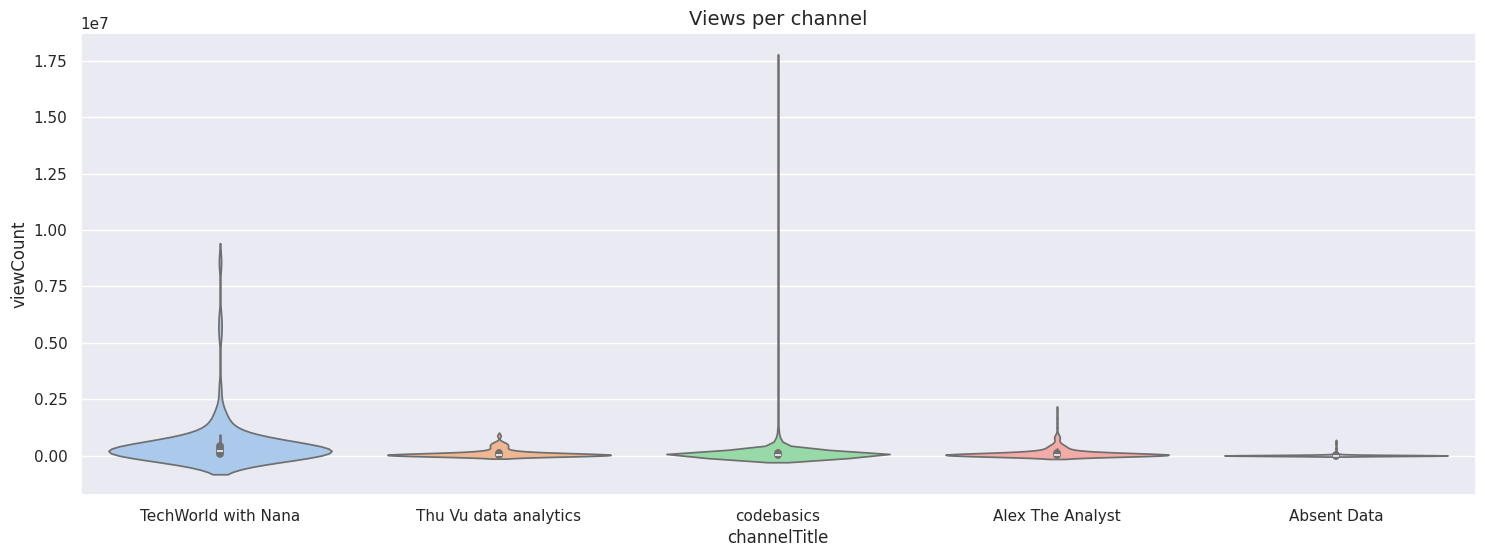

In [25]:
plt.rcParams['figure.figsize'] = (18, 6)

# Use keyword arguments for x and y
sns.violinplot(x='channelTitle', y='viewCount', data=video_df, palette='pastel')

plt.title('Views per channel', fontsize=14)
plt.show()

### 3.1  Số lượt thích và bình luận có quan trọng để video có nhiều lượt xem hơn không?

<Axes: xlabel='likeCount', ylabel='viewCount'>

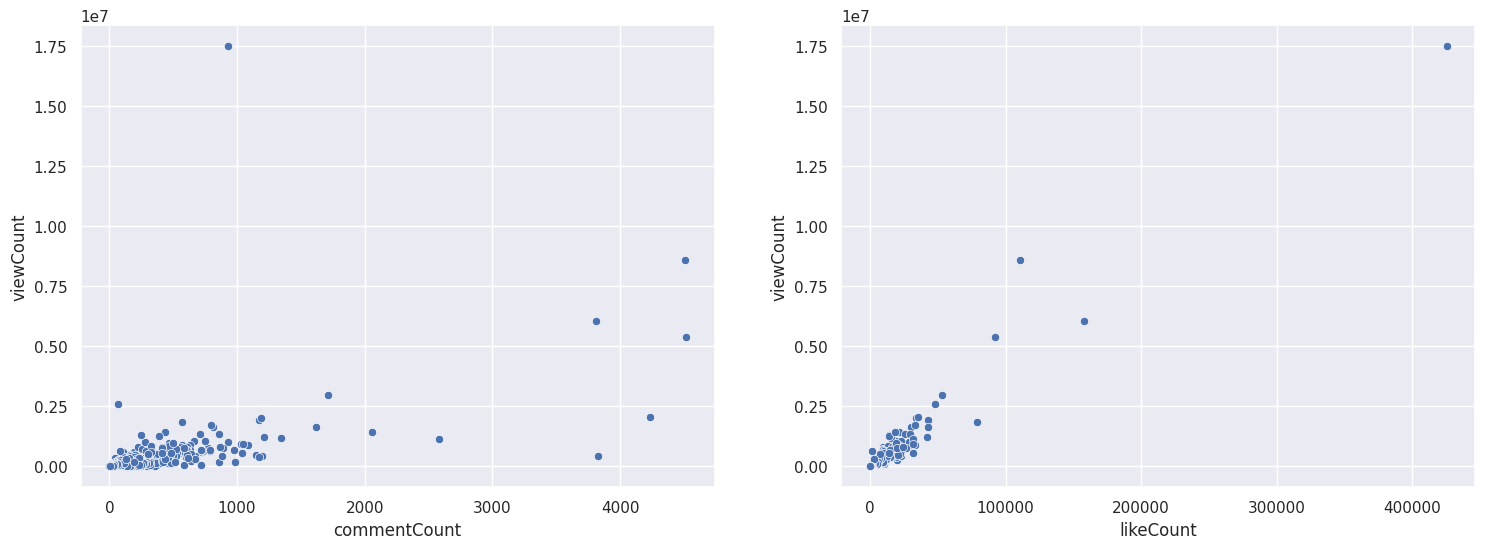

In [26]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

<Axes: xlabel='likeRatio', ylabel='viewCount'>

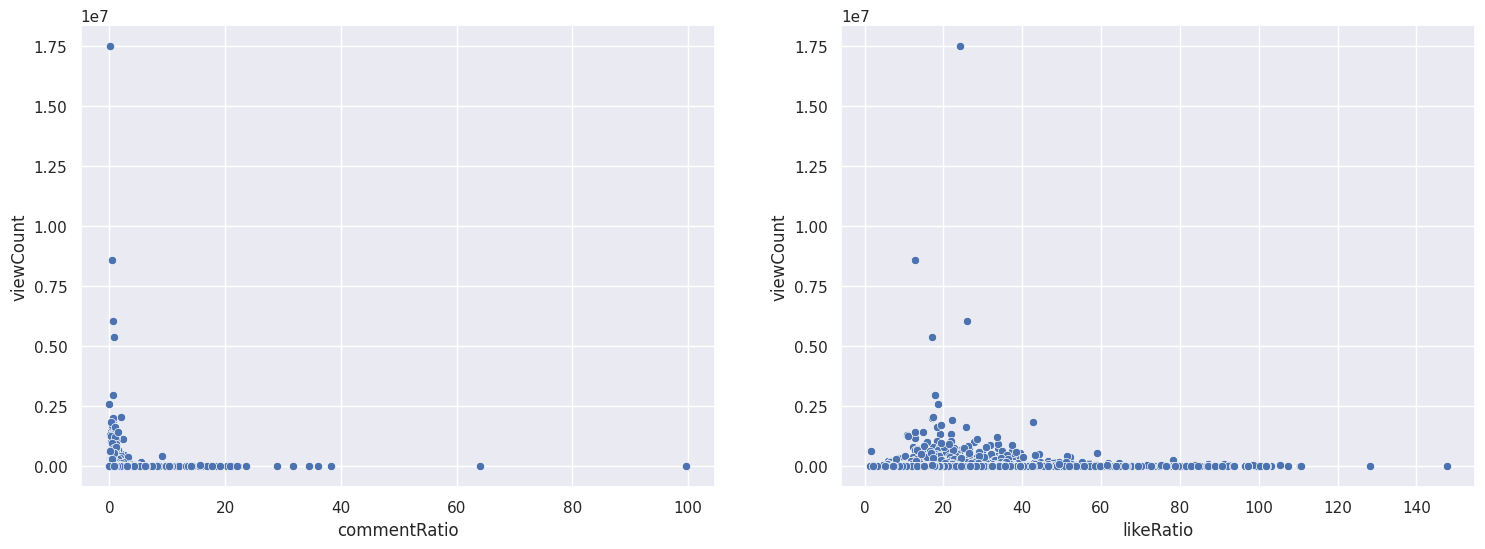

In [27]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

#### 3.2 Thời lượng video có ảnh hưởng đến lượt xem và tương tác (lượt thích/bình luận) không?

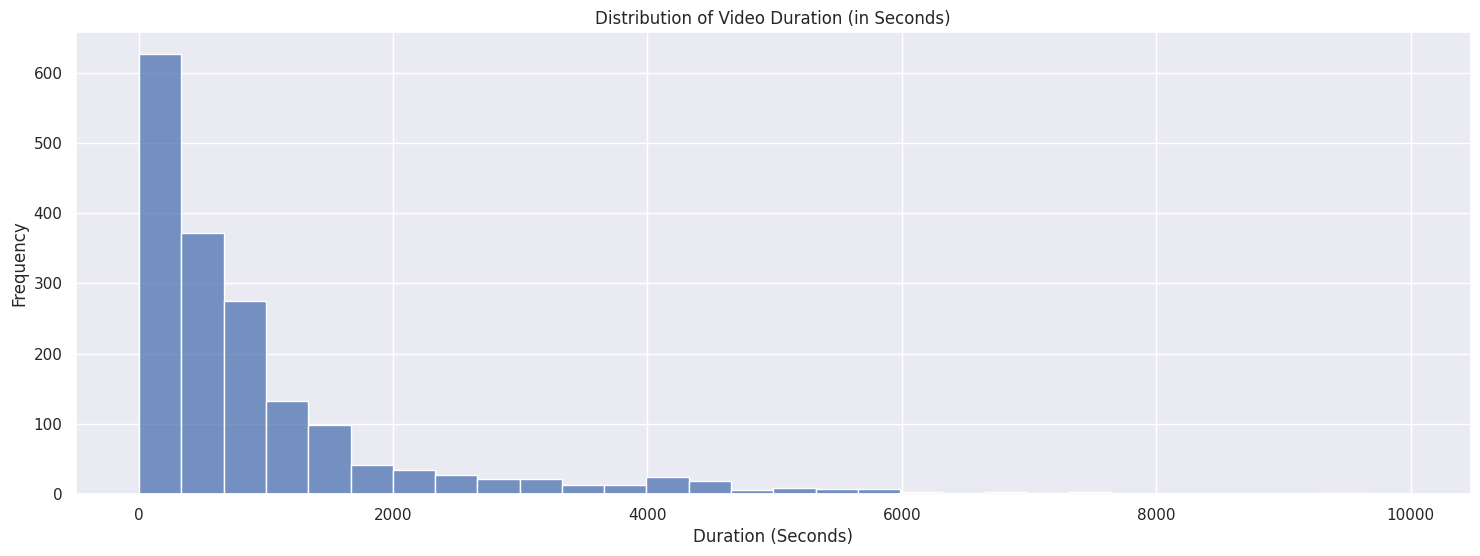

In [28]:
# Convert 'durationSecs' to total seconds (integer)
video_df['durationSecs'] = video_df['durationSecs'].dt.total_seconds()

# Filter and plot the histogram
sns.histplot(data=video_df[video_df['durationSecs'] < 10000], x="durationSecs", bins=30)

plt.title('Distribution of Video Duration (in Seconds)')
plt.xlabel('Duration (Seconds)')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='durationSecs', ylabel='likeCount'>

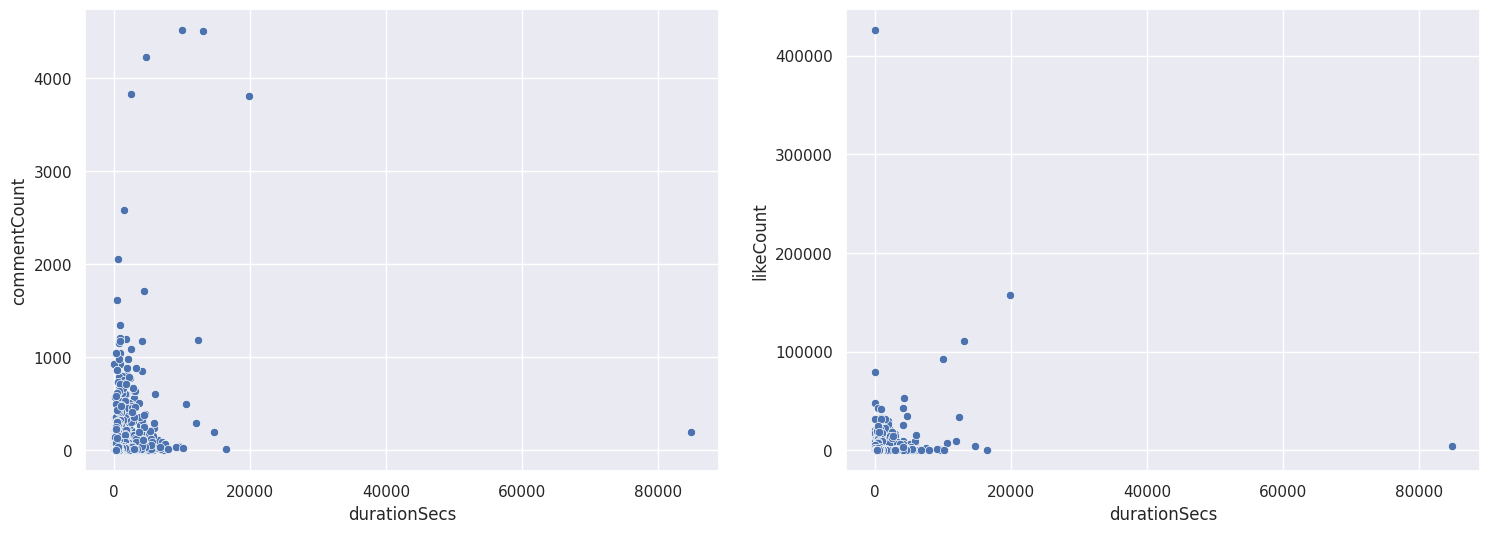

In [29]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

### 3.3  Độ dài tiêu đề có ảnh hưởng đến lượt xem không?

<Axes: xlabel='titleLength', ylabel='viewCount'>

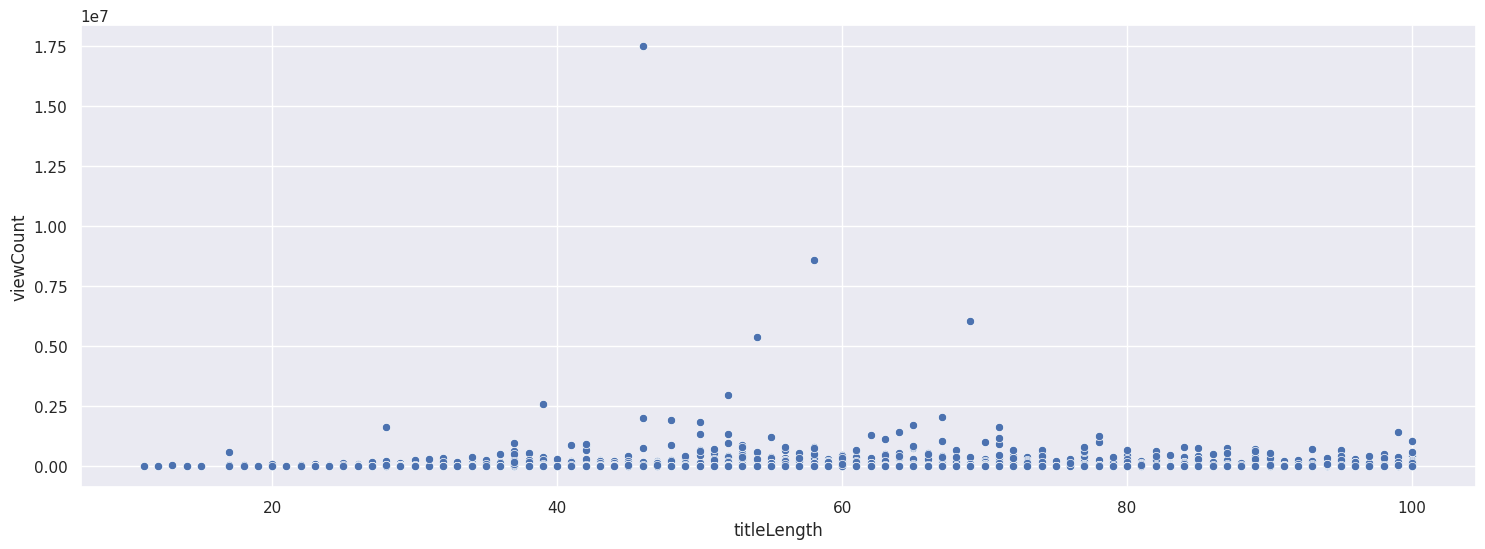

In [30]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

In [31]:
top_10_videos = video_df.nlargest(10, 'commentCount')
top_10_videos

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,published_day_name,durationSecs,tagsCount,likeRatio,commentRatio,titleLength
68,3c-iBn73dDE,TechWorld with Nana,Docker Tutorial for Beginners [FULL COURSE in ...,Full Docker Tutorial | Complete Docker Course ...,"[docker tutorial, docker tutorial for beginner...",2020-10-21 19:26:53+00:00,5396082,92065,None,4514,PT2H46M15S,hd,true,Wednesday,9975.0,20,17.061453,0.836533,54
66,X48VuDVv0do,TechWorld with Nana,Kubernetes Tutorial for Beginners [FULL COURSE...,Full Kubernetes Tutorial | Kubernetes Course |...,"[kubernetes, kubernetes tutorial, learn kubern...",2020-11-06 15:41:47+00:00,8578604,110739,None,4505,PT3H36M55S,hd,false,Friday,13015.0,24,12.908744,0.525144,58
1456,qfyynHBFOsM,Alex The Analyst,Data Analyst Portfolio Project | SQL Data Expl...,Take my Full MySQL Course Here: https://bit.ly...,"[Alex The Analyst, data analyst project, data ...",2021-05-04 11:00:31+00:00,2035809,35179,None,4230,PT1H17M9S,hd,false,Tuesday,4629.0,18,17.280108,2.077798,67
1508,Z2AachB309o,Alex The Analyst,How I Changed Careers to Become a Data Analyst...,Today I go in-depth about how I changed career...,"[Data Analyst, How to become a data analyst, D...",2020-09-10 13:16:00+00:00,417070,12159,None,3825,PT40M54S,hd,false,Thursday,2454.0,16,29.153380,9.171122,82
57,t8pPdKYpowI,TechWorld with Nana,Python Tutorial for Beginners - Learn Python i...,Python Tutorial for Beginners | Full Python Co...,"[python, python tutorial, python tutorial for ...",2021-03-05 14:10:17+00:00,6063855,157559,None,3812,PT5H31M30S,hd,false,Friday,19890.0,21,25.983306,0.628643,69
891,ZhnJ1bkIWWk,codebasics,Bitcoin Mining Fundamentals in Python | Python...,Learn the fundamentals of Bitcoin mining in Py...,"[mine bitcoin python, crypto mining python, bl...",2021-01-03 14:30:11+00:00,1114679,31825,None,2583,PT25M,hd,true,Sunday,1500.0,22,28.550820,2.317259,63
1539,RSlqWnP-Dy8,Alex The Analyst,SQL Basics Tutorial For Beginners | Installing...,Take my Full MySQL Course Here: https://bit.ly...,"[Data Analyst, How to become a data analyst, D...",2020-03-01 00:50:38+00:00,1439870,18431,None,2058,PT9M37S,hd,false,Sunday,577.0,21,12.800461,1.429296,99
42,s_o8dwzRlu4,TechWorld with Nana,Kubernetes Crash Course for Absolute Beginners...,Hands-On Kubernetes Tutorial | Learn Kubernete...,"[kubernetes, kubernetes tutorial for beginners...",2021-09-30 14:14:10+00:00,2954284,52964,None,1716,PT1H12M4S,hd,false,Thursday,4324.0,21,17.927863,0.580851,52
1359,rGx1QNdYzvs,Alex The Analyst,FREE Data Analyst Bootcamp!!,Take my Full Courses and Practice Technical Qu...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-02-07 12:30:11+00:00,1652328,42404,None,1619,PT6M52S,hd,false,Tuesday,412.0,11,25.663186,0.979830,28
1109,8jazNUpO3lQ,codebasics,Machine Learning Tutorial Python - 2: Linear R...,In this tutorial we will predict home prices u...,"[linear regression in python, python linear re...",2018-07-01 19:19:47+00:00,1173109,15028,None,1342,PT15M14S,hd,false,Sunday,914.0,16,12.810404,1.143969,71


### 3.4 Wordcloud cho các từ trong tiêu đề
Vì mình muốn biết những creators đang làm video về chủ đề gì và những thuật ngữ nào thường xuất hiện nhất trong tiêu đề video của họ, mình sẽ tạo một wordcloud cho những từ phổ biến nhất. Trước tiên, chúng ta cần loại bỏ các từ dừng như "you", "I", "the", v.v. không đóng góp nhiều vào ý nghĩa của tiêu đề.

In [32]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if you haven't already
nltk.download('stopwords')

# Initialize stop words
stop_words = set(stopwords.words('english'))

# Remove stop words from video titles
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item.lower() not in stop_words])

# Flatten the list of words and join them into a single string
all_words = [word for title in video_df['title_no_stopwords'] for word in title]
all_words_str = ' '.join(all_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


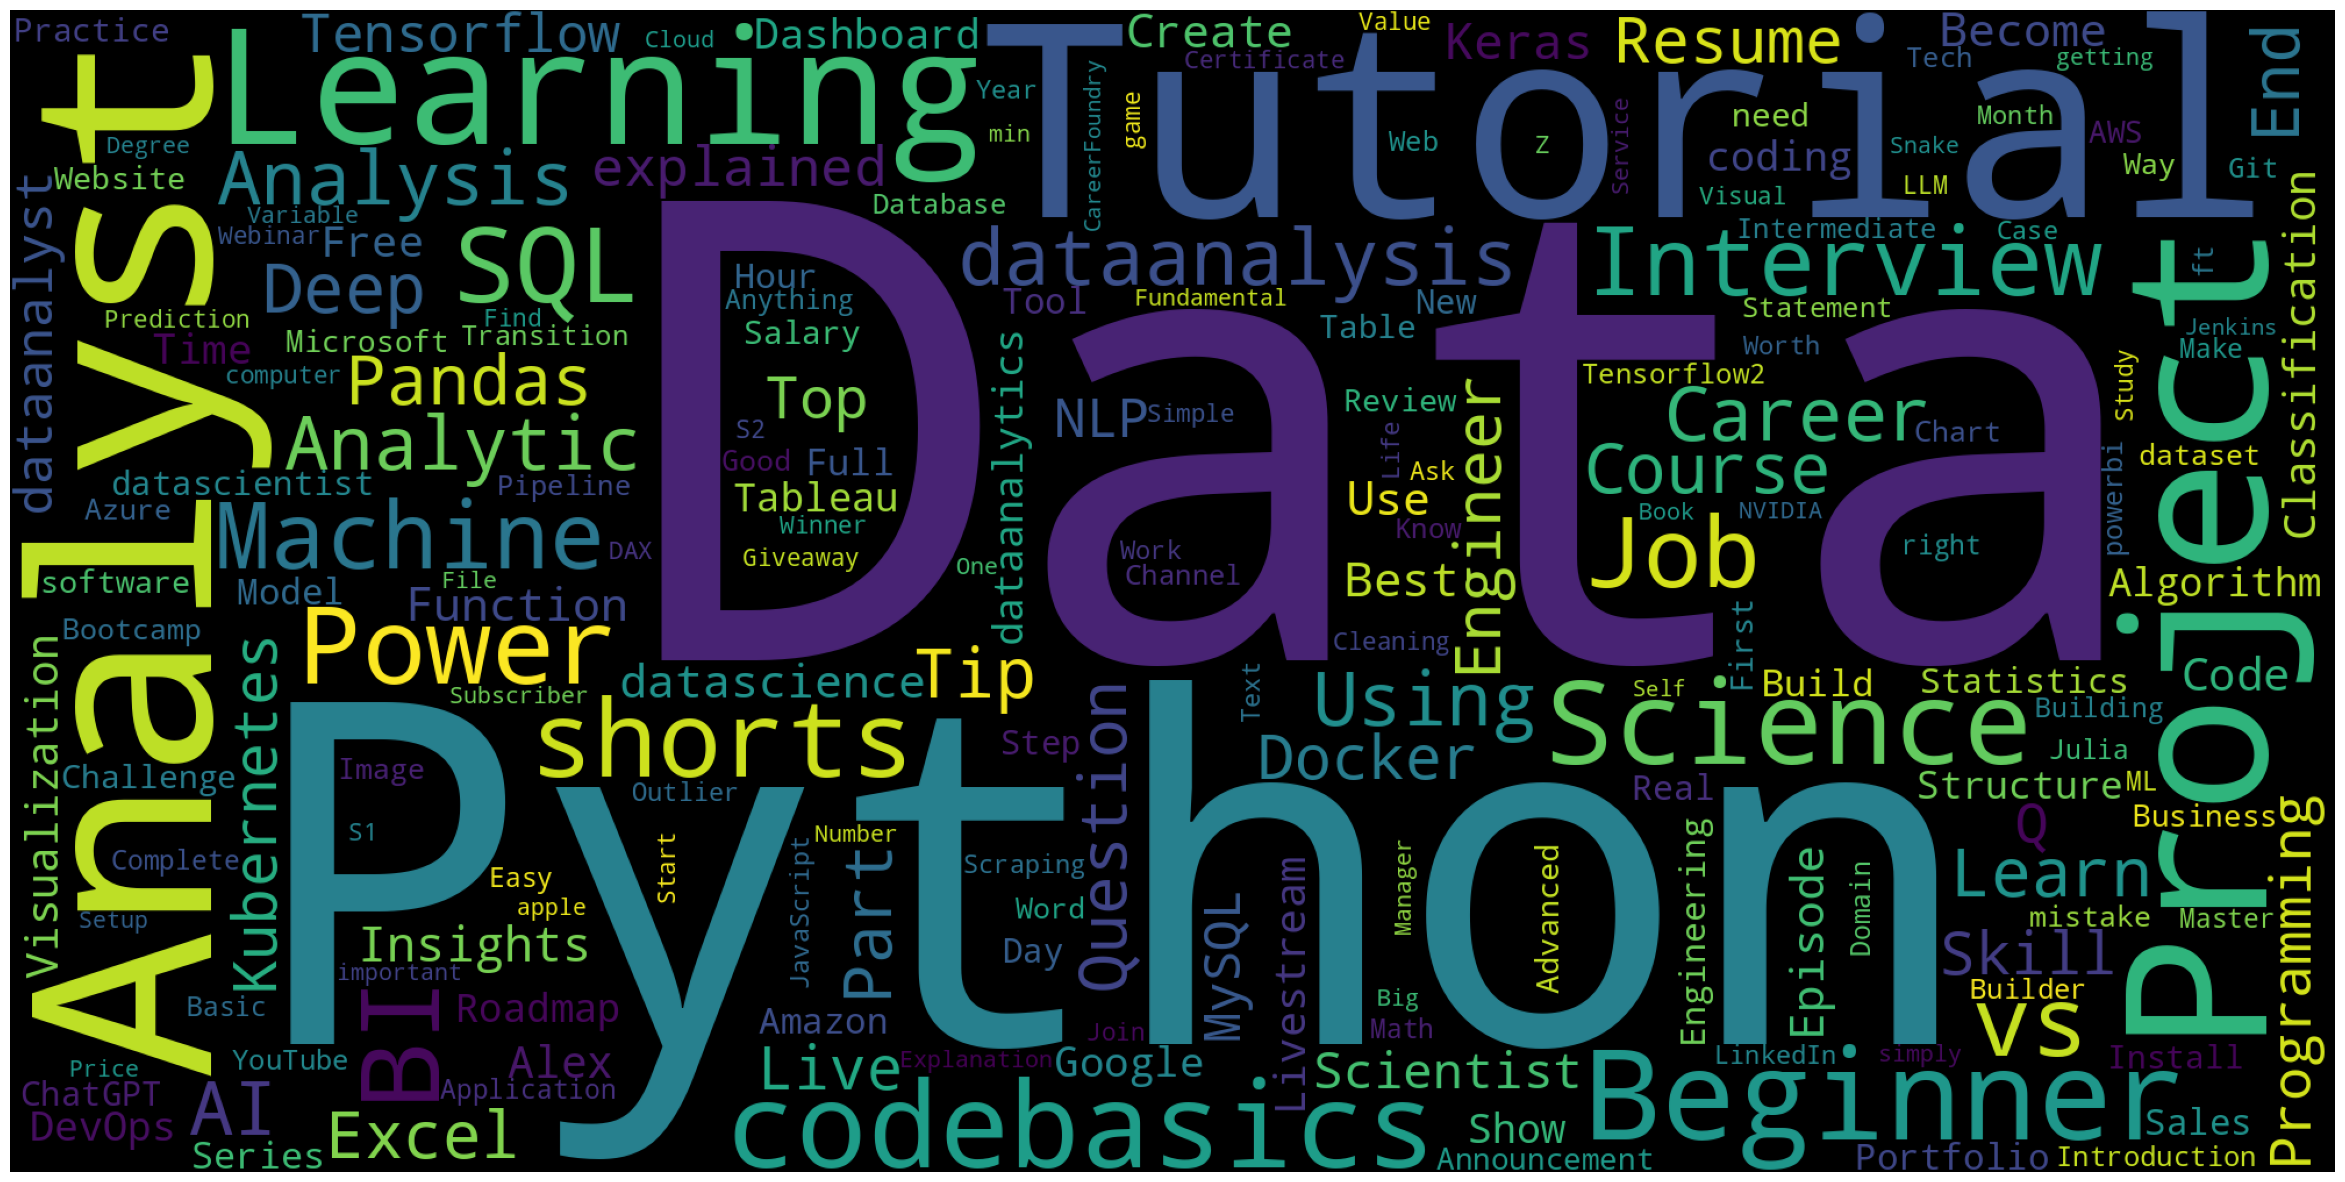

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to plot the word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off")

# Generate the word cloud
wordcloud = WordCloud(width=2000, height=1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(all_words_str)

# Plot the word cloud
plot_cloud(wordcloud)

Có thể thấy rằng những từ phổ biến nhất là Data, Python, Tutorial, Science,  Projects, Analysis, Tutorial, Learning, which is very expected.

### 3.5 Số lượng tags so với lượt views
Có vẻ như hầu hết các video có từ 5 đến 30 thẻ. Mối quan hệ giữa số lượng thẻ và số lượt xem không được thấy rõ ràng, nhưng quá ít thẻ hoặc quá nhiều thẻ dường như có mối tương quan với ít lượt xem hơn

<Axes: xlabel='tagsCount', ylabel='viewCount'>

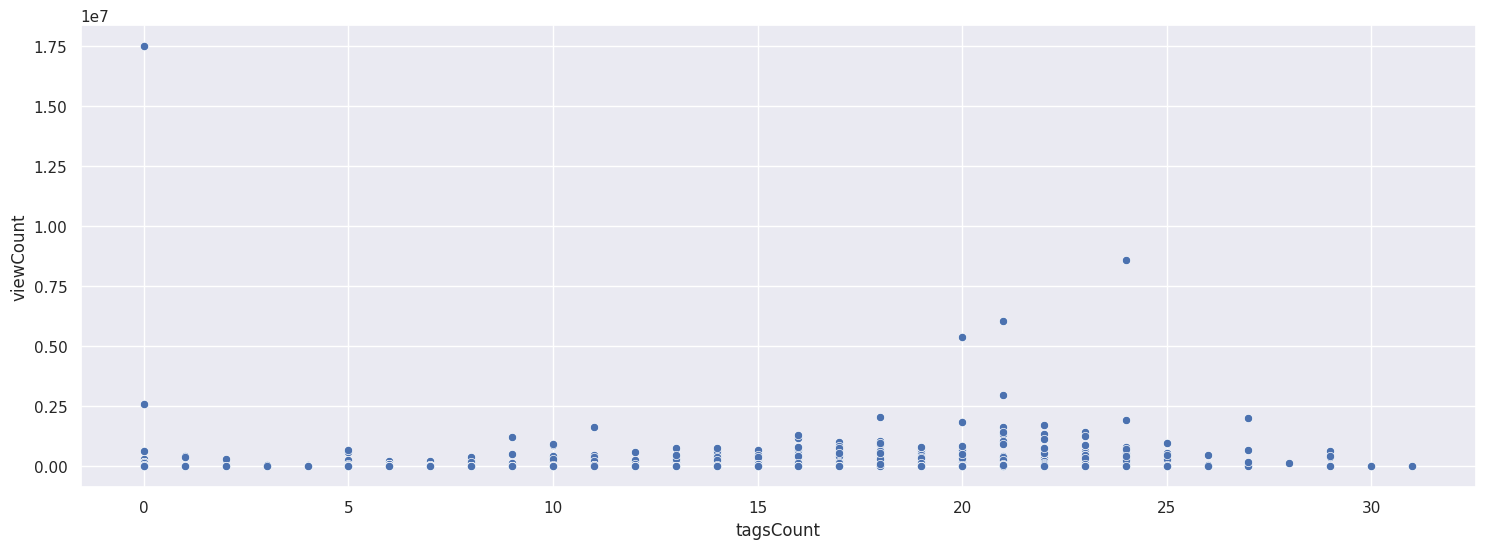

In [34]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")


### 3.6 Ngày nào trong tuần là ngày có nhiều video được tải lên nhất?
Thật thú vị khi thấy nhiều video được tải lên vào Thứ 3 và Thứ 7. Ít video được tải lên vào cuối tuần. Điều này có thể là do bản chất của của lĩnh vực này hướng nhiều hơn đến hướng dẫn và tài liệu nặng, không phù hợp để sử dụng vào cuối tuần. Nhưng nó cũng có thể chỉ có nghĩa là hầu hết creators tạo video của họ vào cuối tuần hoặc trong tuần và tải chúng lên vào đầu tuần hoặc Thứ 7.

In [35]:
unique_values = video_df['published_day_name'].unique()
print("Các giá trị duy nhất trong cột 'published_day_name':", unique_values)

Các giá trị duy nhất trong cột 'published_day_name': ['Tuesday' 'Thursday' 'Monday' 'Wednesday' 'Friday' 'Sunday' 'Saturday']


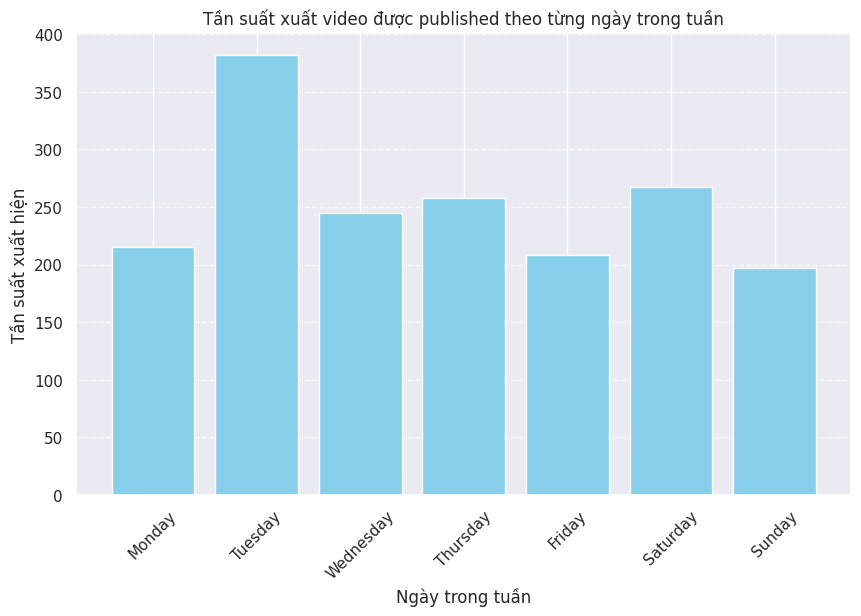

In [36]:
 #Tạo DataFrame day_df từ value_counts của cột published_day_name
day_df = pd.DataFrame(video_df['published_day_name'].value_counts())

# Đặt tên cho cột đếm là 'count'
day_df.columns = ['count']

# Chuyển đổi index thành cột để sắp xếp theo thứ tự mong muốn
day_df = day_df.reset_index().rename(columns={'index': 'dpublished_day_nameay'})

# Định nghĩa thứ tự của các ngày trong tuần
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Đặt cột 'day' thành kiểu categorical với thứ tự mong muốn
day_df['published_day_name'] = pd.Categorical(day_df['published_day_name'], categories=weekdays, ordered=True)

# Sắp xếp DataFrame theo thứ tự của weekdays
day_df = day_df.sort_values('published_day_name')

# Vẽ biểu đồ bar
plt.figure(figsize=(10, 6))
plt.bar(day_df['published_day_name'], day_df['count'], color='skyblue')
plt.xlabel('Ngày trong tuần')
plt.ylabel('Tần suất xuất hiện')
plt.title('Tần suất xuất video được published theo từng ngày trong tuần')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

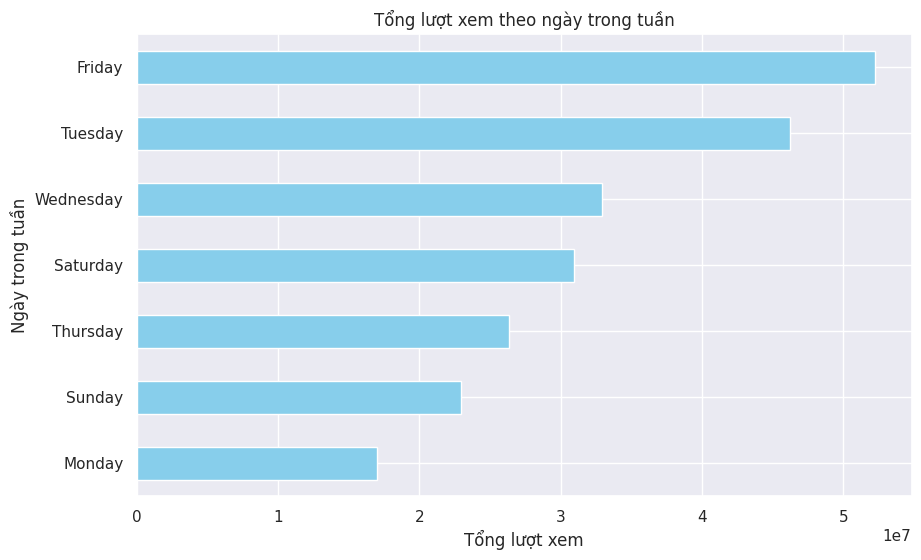

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Giả sử video_df là DataFrame của bạn với các cột 'publishDayName' và 'viewCount'

# Nhóm theo ngày trong tuần và tính tổng của viewCount
views_per_day = video_df.groupby('published_day_name')['viewCount'].sum()

# Vẽ biểu đồ dạng thanh ngang
plt.figure(figsize=(10, 6))
views_per_day.sort_values().plot(kind='barh', color='skyblue')
plt.title('Tổng lượt xem theo ngày trong tuần')
plt.xlabel('Tổng lượt xem')
plt.ylabel('Ngày trong tuần')
plt.show()


### 3.7 Wordcloud for video comments
Chúng ta có thể xem những từ nào được nhắc đến thường xuyên trong các bình luận video. Mình sẽ thực hiện điều này bằng cách visualizing the keywords in a wordcloud.

In [38]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

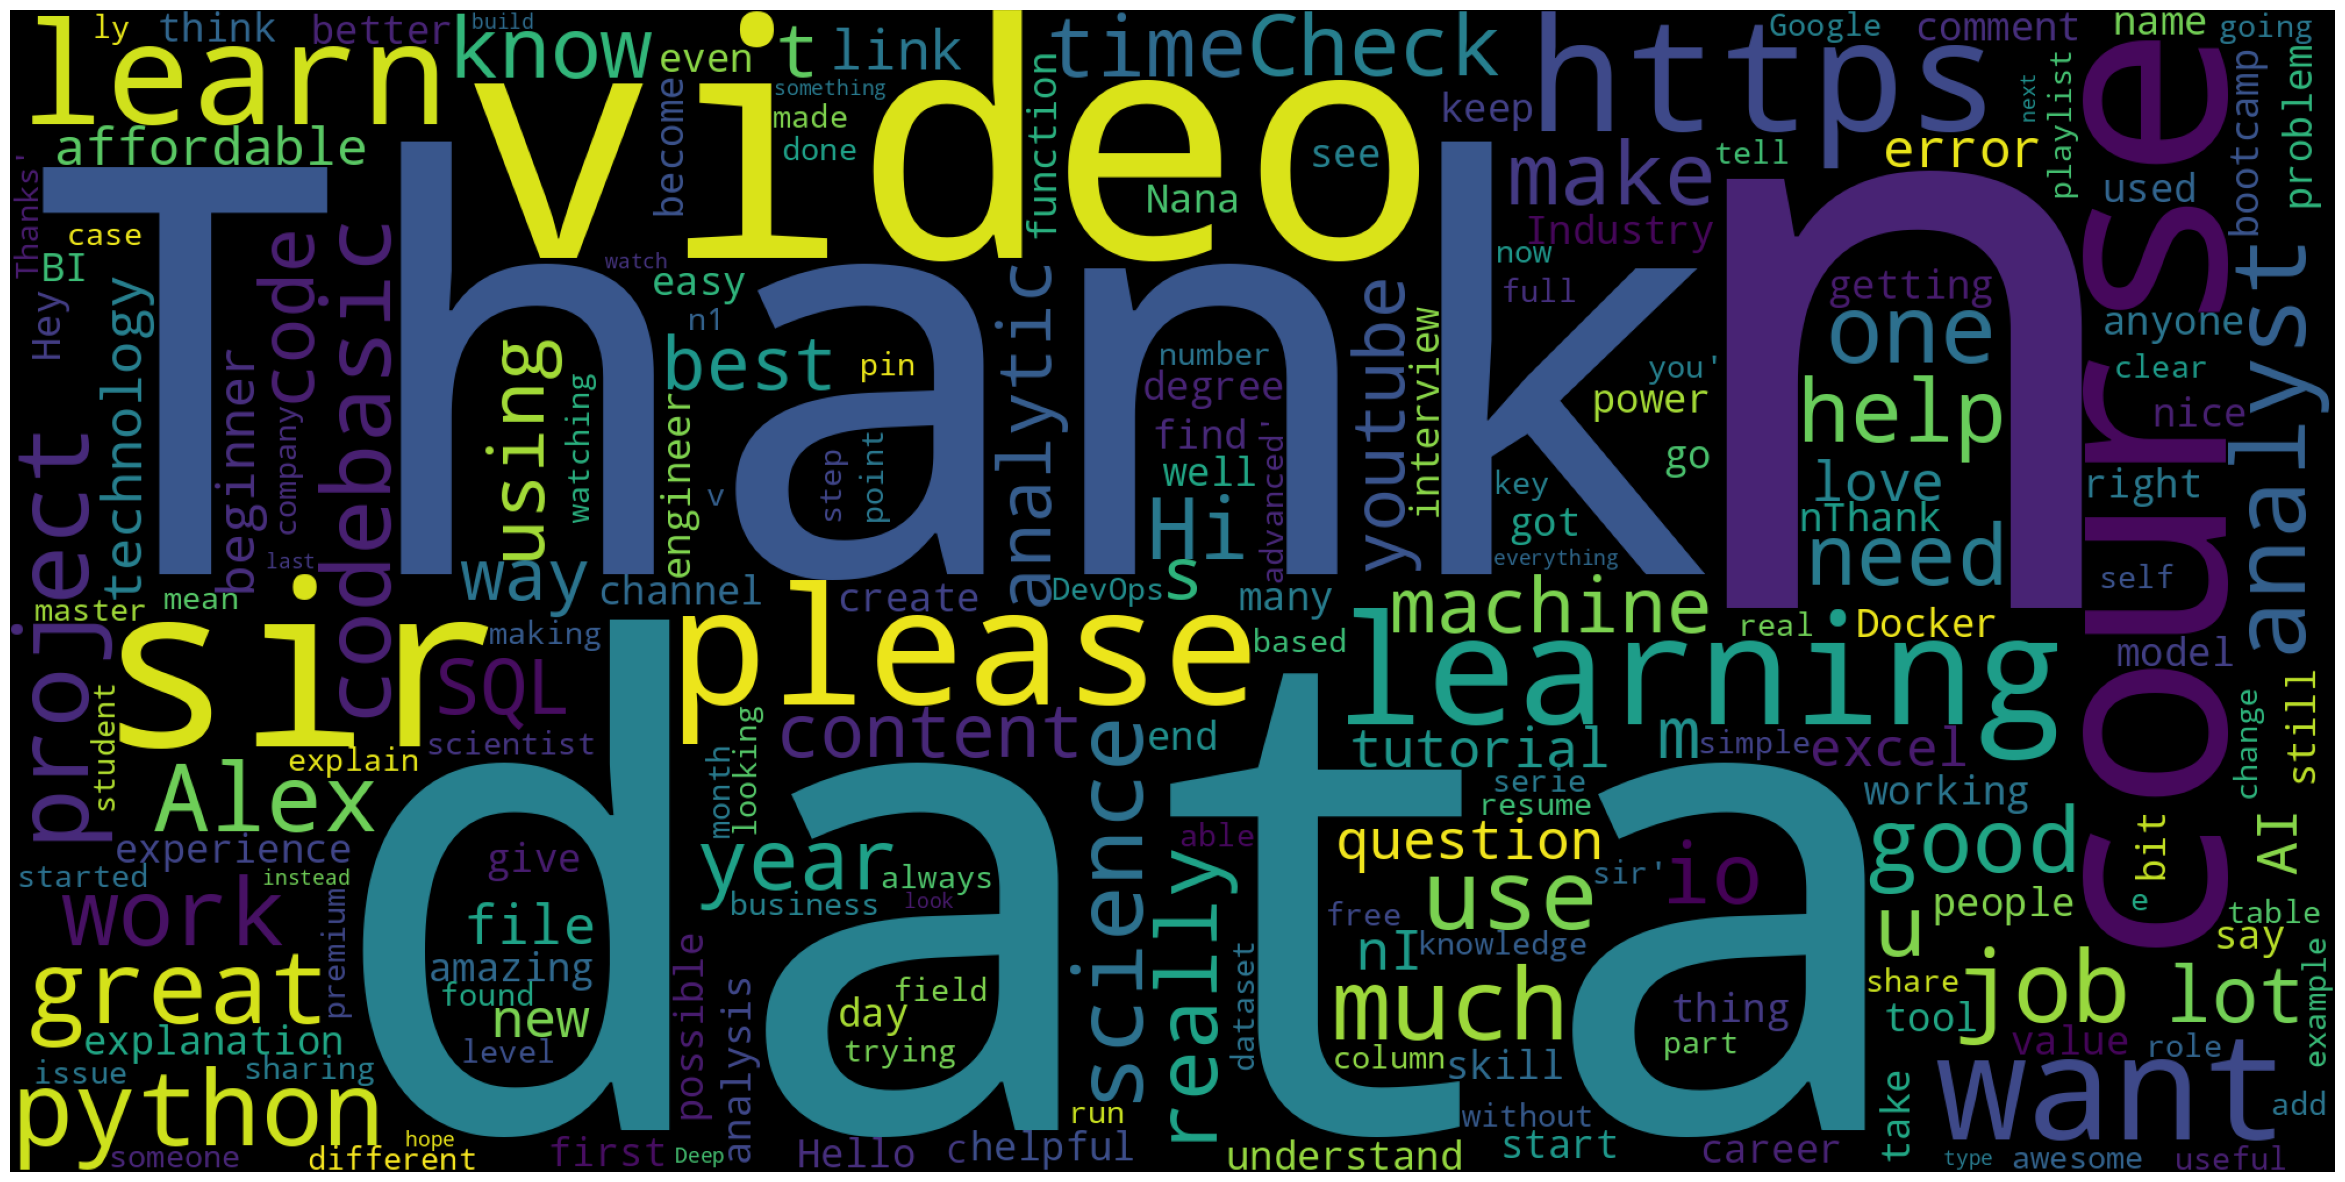

In [39]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

Có thể thấy rằng bên cạnh những từ hiển nhiên như "video", "data", những từ thường gặp nhất là khá tích cực, chẳng hạn như "thank", "great", "learning", "well", "Excellent". Rất nhiều bình luận cũng yêu cầu điều gì đó với từ "Please".  
Vì đây đều là những nội dung về chủ đề chia sẻ kiến thức vậy nên hầu hết sẽ đều là những từ ngữ mang thiên hướng tích cực và biết ơn

## 4. Conclusions
In this Project, we investigated the video data of the five most popular data science/data analyst channels and discovered numerous interesting findings for anyone beginning a YouTube channel in data science or another topic:
- The more likes and comments on a video, the more views it receives. Likes appear to be a better sign of interaction than comments, and the number of likes appears to follow "social proof," implying that the more views the video receives, the more people would like it.
- Most videos contain between 5 and 30 tags.
- The average title length for the most viewed videos is 30-70 characters. excessively short or excessively long titles appear to reduce viewership.
- Videos are typically uploaded on Tuesday and Saturday. Weekends, particularly Sundays, are not popular for releasing new films.
- Comments on videos are generally positive, with a lot of "please" words, indicating possible market holes in material that may be addressed.